# G10. 나를 찾아줘 - Class Activation Map 만들기

## 들어가며

![GC-3-P-1.max-800x600.png](Going_img/GC-3-P-1.max-800x600.png)
<center></center>

이번 시간에는 CAM(Class Activation Map)을 얻기 위한 방법 중 `기본 CAM`과 `Grad-CAM`을 구현해보고 이를 시각화해 보겠습니다. 그리고 CAM을 활용해서 물체의 위치를 찾는 object detection을 수행하고 이를 정답 데이터와 비교해 보겠습니다.

## 실습목표
***
Classification model로부터 CAM을 얻어낼 수 있다.  
CAM으로 물체의 위치를 찾을 수 있다.  
CAM을 시각화 비교할 수 있다.  

## 학습 내용
***
CAM, Grad-CAM용 모델 준비하기  
CAM  
Grad-CAM  
Detection with CAM  


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

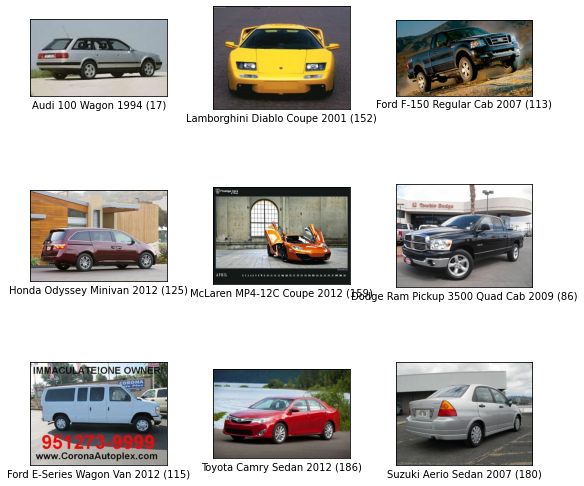

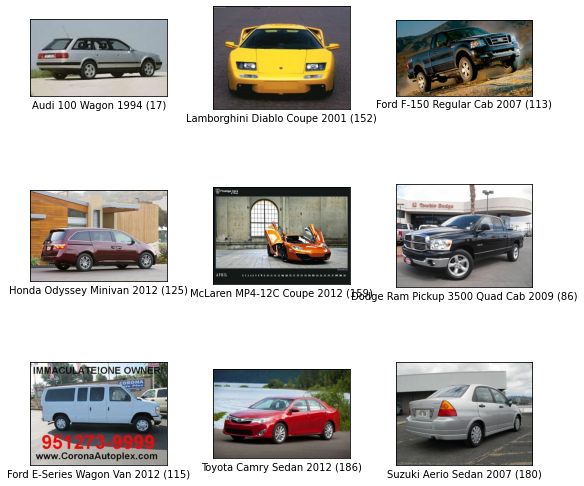

In [4]:
tfds.show_examples(ds_train, ds_info)

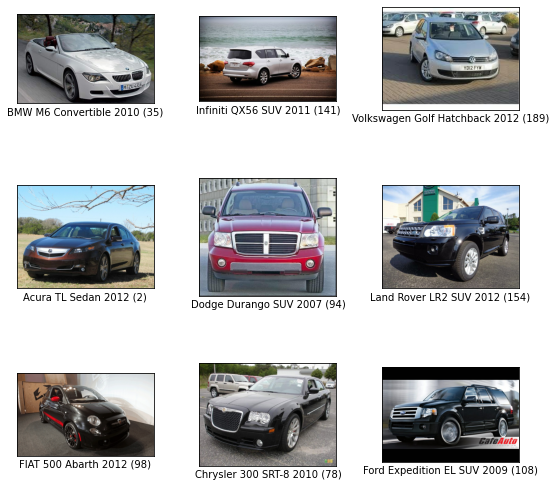

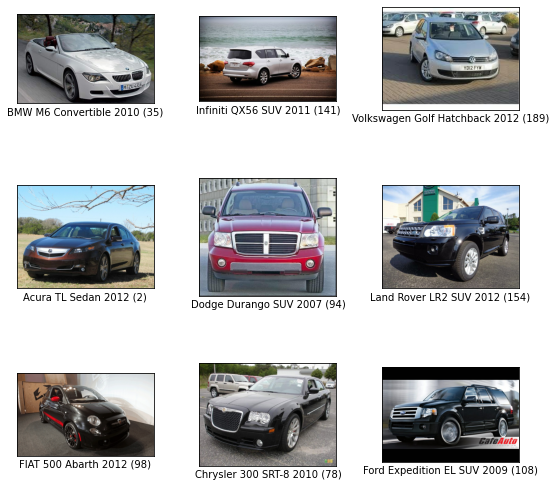

In [5]:
tfds.show_examples(ds_test, ds_info)

## 데이터셋 정보확인

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

## ResNet50모델 불러오기
---
- base_model을 선언하면서 pooling인자에서 'avg'를 주면 마지막에 pooling부분이 GAP로 들어간다?
    - 맞다
    - 설명부분을 보면 "Optional pooling mode for feature extraction when **include_top** is **False**"으로 나와있음
    - pooling인자에 올수 있는 것은 3가지
        1. None
            - 마지막 conv block의 4D tensor의 모양으로 출력이 나갈 것이다
        2. avg
            - 마지막 블럭에서 Global Average Pooling적용하고, 출력의 모양은 2D Tensor로
        3. max
            - Global Max Pooling이 적용된다

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

## 데이터 필터링
---
- Bbox에 대한 데이터는 학습에 필요없음
- resize와 정규화진행

In [9]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [11]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 90s 177ms/step - loss: 4.1483 - accuracy: 0.1655 - val_loss: 5.3334 - val_accuracy: 0.0117
Epoch 2/15
509/509 [==============================] - 92s 180ms/step - loss: 1.6796 - accuracy: 0.6321 - val_loss: 1.8935 - val_accuracy: 0.5207
Epoch 3/15
509/509 [==============================] - 111s 219ms/step - loss: 0.5423 - accuracy: 0.9058 - val_loss: 1.2509 - val_accuracy: 0.6698
Epoch 4/15
509/509 [==============================] - 87s 171ms/step - loss: 0.1565 - accuracy: 0.9861 - val_loss: 1.1152 - val_accuracy: 0.7047
Epoch 5/15
509/509 [==============================] - 89s 175ms/step - loss: 0.0719 - accuracy: 0.9973 - val_loss: 1.0614 - val_accuracy: 0.7205
Epoch 6/15
509/509 [==============================] - 89s 176ms/step - loss: 0.0488 - accuracy: 0.9975 - val_loss: 1.0252 - val_accuracy: 0.7322
Epoch 7/15
509/509 [==============================] - 91s 178ms/step - loss: 0.0312 - accuracy: 0.9984 - val_loss: 1.0064 - val_a

In [13]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

## CAM

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

141


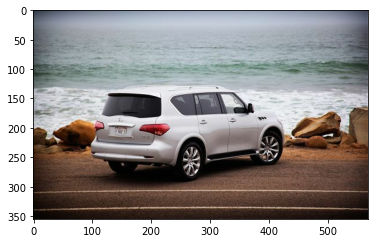

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [16]:
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 만들기 위해서는
1. 특성맵
2. 클래스 별 확률을 얻기위한 소프트맥스 레이어의 가중치
3. 원하는 클래스의 출력값  

3가지가 필요하다.  
또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 **CAM을 입력 이미지 사이즈와 같게** 만들어 함꼐 시각화를 해야할 것이다.  


In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

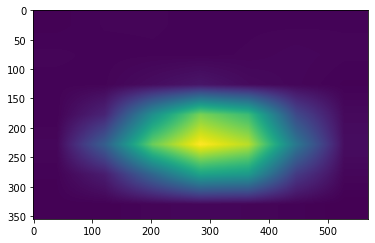

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [19]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

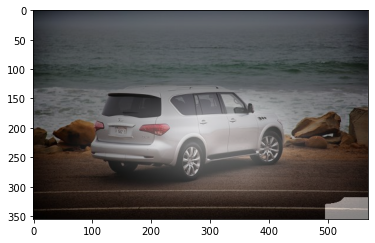

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM

100


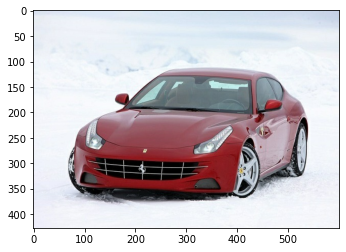

In [21]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [22]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

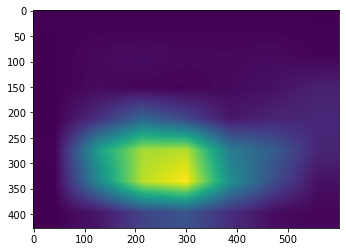

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

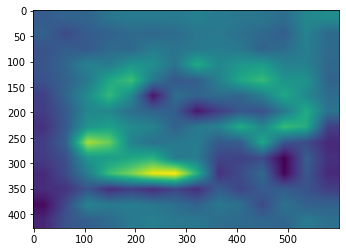

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

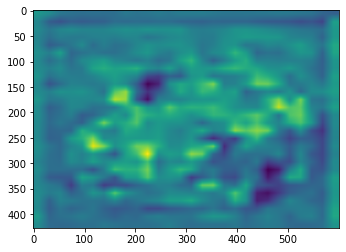

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

## Detection with CAM

141


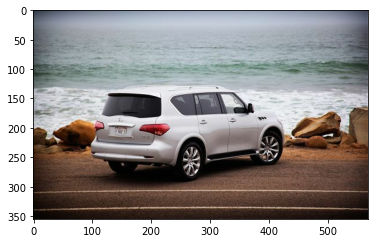

In [26]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

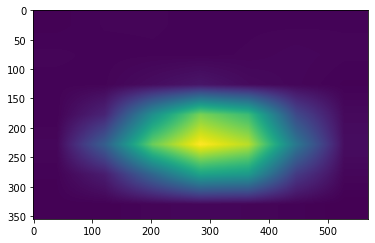

In [27]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [28]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [29]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 52, 126],
       [522, 126],
       [522, 325],
       [ 52, 325]])

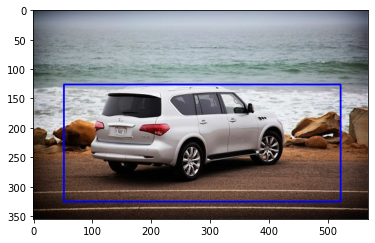

In [30]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

###  IoU

In [31]:

def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]), 
        rect[:,0].min()/float(image.shape[1]), 
        rect[:,1].max()/float(image.shape[0]), 
        rect[:,0].max()/float(image.shape[1])
    ]
    return bbox

In [32]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.35492957746478876,
 0.0913884007029877,
 0.9154929577464789,
 0.9173989455184535]

In [33]:
item['bbox']

array([0.35211268, 0.16695958, 0.8197183 , 0.7557118 ], dtype=float32)

In [34]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [35]:
get_iou(pred_bbox, item['bbox'])

0.588877651786038

## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항/상세기준

1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?  
ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.


2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?  
CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.


3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?  
CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.


## 결과 및 회고




CAM(Class Activation Map)을 얻기 위한 방법 중 기본 CAM과 Grad-CAM을 구현해보고 이를 시각화하는 과정을 공부하였다.  
Fundamental 노드에서 스쳐지나가듯 본 기억은 나지만 CAM을 왜 해야 하는지 필요성을 알지 못하고 넘어 갔던 과정이었다. 이번 과제를 통해서 CAM(Class Activation Map)을 사용하는 이유와 그 이외에 방법 등을 좀더 알 수 있었다.  

CAM은 특정 클래스가 어디 위치에 있는지 보여주는 이미지로, 특정 범주에 대한 class activation map은 해당 범주를 식별하기 위해 CNN에서 사용하는 discriminative image region을 나타낸다.  
기존 CAM의 단점은 Global Average Pooling 레이어가 필요하다는 것인데, GAP가 없는 레이어는 마지막 convolutional layer 뒤에 GAP를 붙여서 fine-tuning 해야 한다는 문제와, 이로 인한 약간의 성능 감소를 동반한 문제가 있습니다. 또한 같은 이유로 마지막 layer에 대해서만 CAM 결과를 얻을 수 있는데, Grad-CAM은 Global Average Pooling 레이어에 의존하지 않는 아이디어로 CAM의 문제를 해결하였다.
